In [1]:
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import scipy.stats as ss
from datetime import datetime
import wrds
random.seed(420)

In [2]:
#mdp:
#goqhuB-1hafqe-dojvix
db = wrds.Connection(wrds_username = 'antb95')

Enter your WRDS username [bedanian]:antb95
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [3]:
msft = db.raw_sql("select prc, date from crsp.dsf where permco in (8048.0) and date >='2011-03-10' and date <='2016-03-10'")
intc = db.raw_sql("select prc, date from crsp.dsf where permco in (2367.0) and date >='2011-03-10' and date <='2016-03-10'")
yhoo = db.raw_sql("select prc, date from crsp.dsf where permco in (14521.0) and date >='2011-03-10' and date <='2016-03-10'")

In [4]:
msft['date'] = pd.to_datetime(msft['date'], format='%Y-%m-%d')
intc['date'] = pd.to_datetime(intc['date'], format='%Y-%m-%d')
yhoo['date'] = pd.to_datetime(yhoo['date'], format='%Y-%m-%d')

In [5]:
msft_r = np.log(msft['prc']) - np.log(msft['prc'].shift(1))
intc_r = np.log(intc['prc']) - np.log(intc['prc'].shift(1))
yhoo_r = np.log(yhoo['prc']) - np.log(yhoo['prc'].shift(1))

In [6]:
df_stock = pd.DataFrame()
df_stock['date'] = msft['date']
df_stock['msft'] = msft['prc']
df_stock['intc'] = intc['prc']
df_stock['yhoo'] = yhoo['prc']

In [7]:
df_return = pd.DataFrame()
df_return['date'] = pd.to_datetime(msft['date'], format='%Y-%m-%d').copy()
df_return['msft'] = msft_r
df_return['intc'] = intc_r
df_return['yhoo'] = yhoo_r
df_return.dropna(inplace = True)

In [8]:
cov_matrix = df_return.set_index('date').rolling(502).cov().dropna()
mean = df_return.set_index('date').rolling(502).mean().dropna()

In [9]:
#msft
m = (intc[intc['date'] == '2013-03-11']['prc'].values[0]*100)/msft[msft['date'] == '2013-03-11']['prc'].values[0]
#yahoo
n = (intc[intc['date'] == '2013-03-11']['prc'].values[0]*100)/yhoo[yhoo['date'] == '2013-03-11']['prc'].values[0]
#lambda
lbda = np.array([m,100,n])

In [18]:
M = 100000
VAR_95 = []
VAR_99 = []
date = cov_matrix.index.get_level_values('date').values
for i in date :
    temp_cov = cov_matrix.loc[i,:].values
    temp_mean = mean.loc[i,:].values
    rd_vec = np.random.multivariate_normal(temp_mean,temp_cov,M)
    #mean var method
    L = rd_vec * lbda * df_stock[df_stock['date'] == i][['msft','intc','yhoo']].values
    L = -1*np.sum(L, axis = 1)
    VAR_95 += [np.mean(L)+np.std(L)*ss.norm.ppf(0.95)]
    VAR_99 += [np.mean(L)+np.std(L)*ss.norm.ppf(0.99)]

In [19]:
LOSS = []
for i in date:
    temp = (np.exp(df_return[df_return['date'] == i][['msft','intc','yhoo']].values)-1) * lbda * df_stock[df_stock['date'] == i][['msft','intc','yhoo']].values
    temp = -1*np.sum(temp, axis = 1)
    LOSS += [temp]

In [20]:
up_95 = [0]*len(LOSS)
up_99 = [0]*len(LOSS)
val_95 = []
val_99 = []
for k in range(0,len(LOSS)):
    if LOSS[k] > VAR_95[k]:
        up_95[k] = 1
        val_95 += [[date[k],VAR_95[k]]]
    if LOSS[k] > VAR_99[k]:
        up_99[k] = 1
        val_99 += [[date[k],VAR_99[k]]]
print('Above 95% :',np.sum(up_95))
print('Above 99% :',np.sum(up_99))

val_99 = np.array(val_99)
val_95 = np.array(val_95)

Above 95% : 145
Above 99% : 51


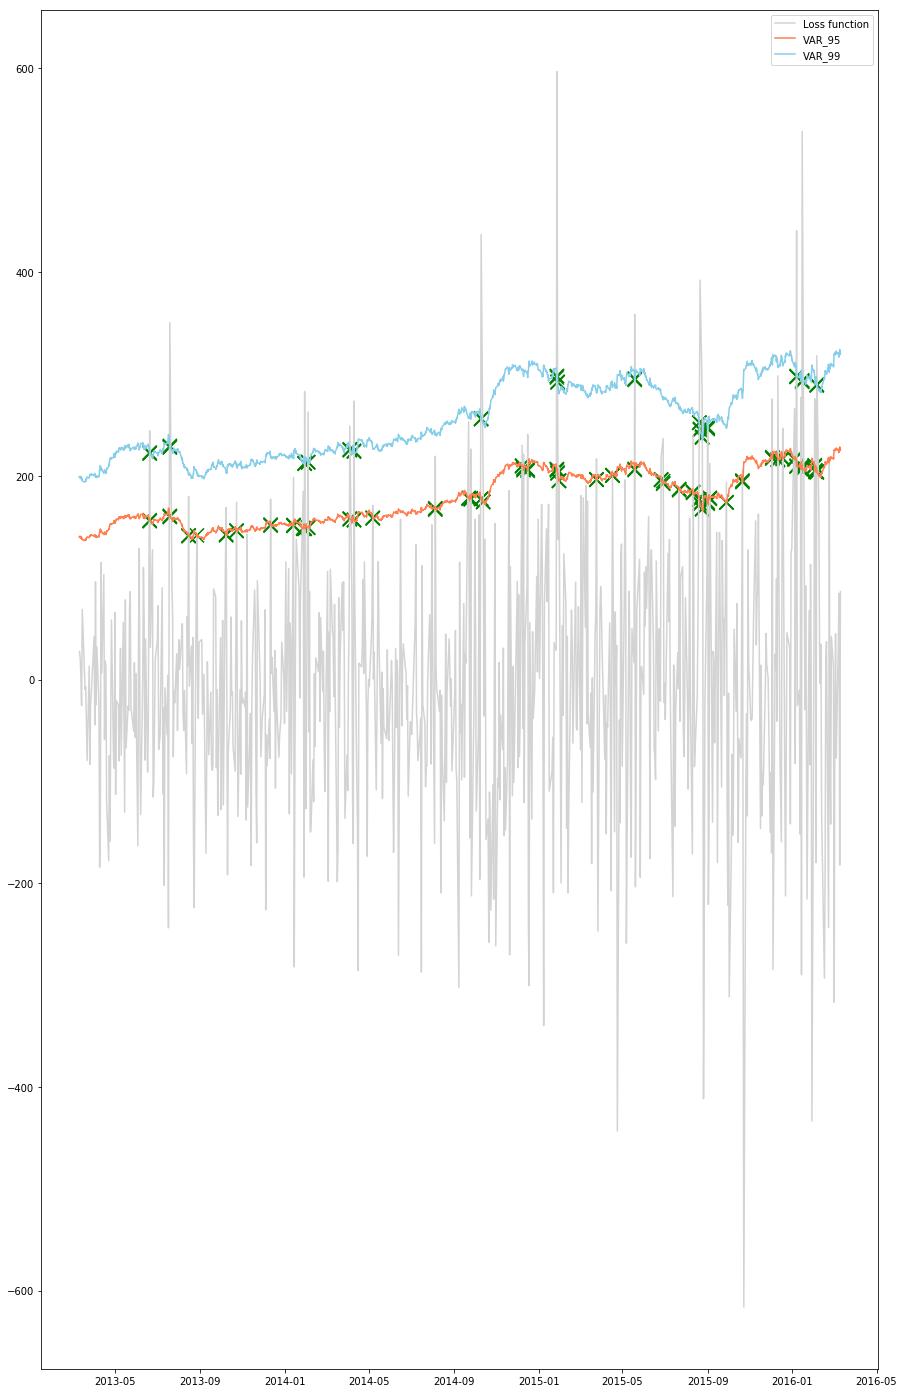

In [21]:
plt.figure(1, figsize = (15, 25))
s = [200]*len(val_95)
plt.scatter(val_95[:,0],val_95[:,1],color = 'g',marker = 'x', s=s)
plt.scatter(val_99[:,0],val_99[:,1],color = 'g',marker = 'x', s=s)
plt.plot(date,LOSS,color = 'lightgrey',label = 'Loss function')
plt.plot(date,VAR_95,color = 'coral',label = 'VAR_95')
plt.plot(date,VAR_99,color = 'skyblue',label = 'VAR_99')
plt.legend()
plt.show()

In [26]:
1 - ss.binom.cdf(51, 2271, 0.01)

8.133254769671083e-08

In [25]:
1 - ss.binom.cdf(145, 2271, 0.05)

0.0015015911532101356

In [15]:
M = 10000000
rd_vec1 = np.random.normal(0,1,M) - 10* ss.bernoulli.rvs(0.009,size = M)
rd_vec2 = np.random.normal(0,1,M) - 10* ss.bernoulli.rvs(0.009,size = M)
rd_vec3 = rd_vec1 + rd_vec2
#mean var method
rd_vec1 = np.sort(rd_vec1)[::-1]
rd_vec2 = np.sort(rd_vec2)[::-1]
rd_vec3 = np.sort(rd_vec3)[::-1]

#VAR_99_1 = np.mean(rd_vec1)+np.std(rd_vec1)*ss.norm.ppf(0.99)
#VAR_99_2 = np.mean(rd_vec2)+np.std(rd_vec1)*ss.norm.ppf(0.99)
#VAR_99_3 = np.mean(rd_vec3)+np.std(rd_vec1zz)*ss.norm.ppf(0.99)
VAR_99_1 = ss.norm.ppf(0.99,np.mean(rd_vec1),np.std(rd_vec1))
VAR_99_2 = ss.norm.ppf(0.99,np.mean(rd_vec2),np.std(rd_vec2))
VAR_99_3 = ss.norm.ppf(0.99,np.mean(rd_vec3),np.std(rd_vec3))

print(VAR_99_1,VAR_99_2,VAR_99_3)

3.109129477050947 3.105650368934645 4.342134590408982


In [17]:
    #L = (np.exp(rd_vec)-1) * lbda * df_stock[df_stock['date'] == i][['msft','intc','yhoo']].values
    #L = -1*np.sum(L, axis = 1)
    #L = np.sort(L)[::-1]
    #VAR_95 += [L[int(M*(1-0.95))]]
    #VAR_99 += [L[int(M*(1-0.99))]]